# AI Content Detector

This notebook demonstrates different machine learning and deep learning methods for AI content detection, with a focus on model explainability.

## Introduction

The rise of AI-generated content presents unique challenges for both everyday internet users and machine learning practitioners. As generative models become more sophisticated and accessible, distinguishing between authentic and synthetic media has become increasingly important.

From a user perspective, AI-generated images can spread false information and create misleading narratives. The [AI Incident Database](https://incidentdatabase.ai/) documents numerous cases where synthetic media has caused real-world harm, from deepfakes damaging reputations to fabricated images spreading misinformation on social platforms.

For machine learning researchers and engineers, the proliferation of AI-generated content creates a technical problem: model collapse. When AI models are trained on datasets contaminated with AI-generated images, their performance degrades over successive generations. This feedback loop, where AI trains on AI-generated data, leads to quality deterioration and reduced model diversity.

The detection of AI-generated imagery serves two critical purposes: (1) flagging potentially misleading content for social media users, and (2) maintaining data quality in machine learning pipelines. Both traditional machine learning approaches using engineered features and modern deep learning techniques can be applied to this classification task.

This project implements and compares two approaches to AI content detection using the Kaggle AI vs. Real dataset: a Random Forest classifier with hand-crafted frequency-domain features, and a fine-tuned ResNet50 convolutional neural network.

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import kagglehub
import os
import pandas as pd
from pathlib import Path

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

from PIL import Image
import numpy as np
import scipy.stats
from scipy.fft import dct, fft, fft2

import joblib

import matplotlib.pyplot as plt

from lime.lime_tabular import LimeTabularExplainer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from dataclasses import dataclass

from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch

from sklearn.inspection import permutation_importance

from torchvision import transforms
from torchvision.transforms import v2
import torch

from torch.utils.data import Dataset, DataLoader, random_split
from torch import rand

from tkinter import N
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV



## Data Loading

Loading the [AI vs. Real](https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images/) dataset from Kaggle. This dataset contains AI-generated and real images for training classifiers.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("cashbowman/ai-generated-images-vs-real-images")

print("Path to dataset files:", path)

!ls $path
!echo
!ls $path/AiArtData/AiArtData 2>/dev/null | head -3
!echo
!ls $path/RealArt/RealArt 2>/dev/null | head -3
!echo

!find $path -maxdepth 2 | head

!tree -L 2 $path

Path to dataset files: /home/vscode/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1
AiArtData  RealArt

-how-important-people-from-the-past-really-looked-11-Pics-5ffd5c0f4d77f__880.jpg
-s-fluffy-fur-and-round-features-immediately-melted-the-viewer-s-heart-photo.jpg
-using-generative-ai-technology-landscape-pattern-abstract-concept-269270897.jpg

-Skills-Promo-A-Total-Artist-All-of-North-Wests-Impressive-Drawings-Photos-5.jpg
-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpg
0182.png

/home/vscode/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1
/home/vscode/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1/AiArtData
/home/vscode/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1/AiArtData/AiArtData
/home/vscode/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1/RealArt
/home/vscode/.cache/kag

In [ ]:
base = Path(path)
ai_dir = base/"AiArtData"/"AiArtData"
real_dir = base/"RealArt"/"RealArt"

ai_files = list(ai_dir.glob("*"))
real_files = list(real_dir.glob("*"))

ai_files

[PosixPath('/home/vscode/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1/AiArtData/AiArtData/psychedelic-planet-surreal-landscape-water-painting-ai-generated-art_843679-2589.jpg'),
 PosixPath('/home/vscode/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1/AiArtData/AiArtData/psychedelic-revelation-ai-artwork-718_300x2x.webp'),
 PosixPath('/home/vscode/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1/AiArtData/AiArtData/6487517289657f25a1e7febf_How20Generative20AI20Works20to20Create20AI20Generated20Photos.jpg'),
 PosixPath('/home/vscode/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1/AiArtData/AiArtData/y5aca20it7v1kb9qs0ce.jpg'),
 PosixPath('/home/vscode/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1/AiArtData/AiArtData/wild-animals-tiny-version-ai-01.jpg'),
 PosixPath('/home/vscode/.cache/kagglehub/datasets/cashbow

In [ ]:
"""
I may add everything as features from kurtosis (or a couple of different moments) to DCT and fft coefficients 
Random Forest does feature importance internally, so they should only improve the result and I wont
have to test different feature inclusions, I can just visualize attributions or importance maybe with
Lime

I also have the choice of looking at the entire image or doing convolutions/sliding windows, or I can
include that as another feature?
"""

def extract_higher_order_moments_from_image(path: Path):
    """
    This function will take in a path, and (based off of class) extract the higher order moments,
    I have also heard of and might look into Discrete Cosine Transforms or Discrete Wavelet Transform, and
    Fourier Coefficients (if these are releveant)
    
    Intended to be used on a dataframe like (image_path, label, feature), and we can train a sci-kit
    learn classifier

    Input Arg: Image or Path (will convert to PIL representation)
    Returns: float
    """

    #for channel in ["L", "R", "G", "B"]:
    image = Image.open(path).convert("L")
    grey_array_2D = np.array(image)
    grey_array = grey_array_2D.flatten()

    results = {}

    results["mean"] = np.mean(grey_array)
    results["variance"] = scipy.stats.variation(grey_array)
    results["skewness"] = scipy.stats.skew(grey_array)
    results["kurtosis"] = scipy.stats.kurtosis(grey_array)
    results["fifth_moment"] = scipy.stats.moment(grey_array, 5)
    results["sixth_moment"] = scipy.stats.moment(grey_array, 6)
    results["seventh_moment"] = scipy.stats.moment(grey_array, 7)
    results["eighth_moment"] = scipy.stats.moment(grey_array, 8)

    # DCT coefficients (from computerphile's video)
    # an NxM image returns an NxM coefficient matrix, it tells you the frequencies of the cosine functions that make up the image (awful feature for random forest)
    # the top-left value in the matrix is called DC (direct current), because it is flat and tells us the intensity of the image
    # the other higher frequencies are AC, alternating in frequency, the bottom right has the highest frequency and variations in its pattern
    # In compression, we typically center and quantize these coeffs to make them zero before doing huffman encoding, meaning we can represent 
    # an image almost exactly the same with a simpler/generalized DCT matrix. For these purposes, we probably don't want to do this as we want to
    # pay attention to tiny details like too-high frequency/too-low frequency patterns. also importantly in compression we usually segment an image into
    # 8x8 blocks. I'm not sure what difference this could make,

    dct_coeffs = dct(dct(grey_array_2D, axis=0, norm='ortho'), axis=1, norm='ortho')
    results["dct_dc"] = dct_coeffs[0, 0]

    h, w = dct_coeffs.shape
    low_freq = np.abs(dct_coeffs[:h//4, :w//4]).sum()
    mid_freq = np.abs(dct_coeffs[h//4:h//2, w//4:w//2]).sum()
    high_freq = np.abs(dct_coeffs[h//2:, w//2:]).sum()
    total_energy = np.abs(dct_coeffs).sum()
    
    results["dct_low_freq_ratio"] = low_freq / (total_energy + 1e-10)
    results["dct_mid_freq_ratio"] = mid_freq / (total_energy + 1e-10)
    results["dct_high_freq_ratio"] = high_freq / (total_energy + 1e-10)

    # set top left to 0 for AC

    dct_coeffs[0, 0] = 0

    results["dct_ac_mean"] = np.mean(np.abs(dct_coeffs))
    results["dct_ac_std"] = np.std(dct_coeffs)
    results["dct_ac_max"] = np.max(np.abs(dct_coeffs))

    # FFT
    fft_coeffs = fft2(grey_array_2D)
    fft_magnitude = np.abs(fft_coeffs)

    results["fft_dc"] = fft_magnitude[0, 0]

    ac_magnitude = fft_magnitude.copy()
    ac_magnitude[0, 0] = 0
    
    results["fft_ac_mean"] = np.mean(ac_magnitude)
    results["fft_ac_std"] = np.std(ac_magnitude)
    results["fft_ac_max"] = np.max(ac_magnitude)

    # frequency bands
    fft_shifted = np.fft.fftshift(fft_magnitude)
    h, w = fft_shifted.shape
    center_h, center_w = h // 2, w // 2

    # Create circular masks for frequency bands
    y, x = np.ogrid[:h, :w]
    radius_low = min(h, w) // 8
    mask_low = (x - center_w)**2 + (y - center_h)**2 <= radius_low**2
    low_freq_energy = fft_shifted[mask_low].sum()
    
    radius_high = min(h, w) // 3
    mask_high = (x - center_w)**2 + (y - center_h)**2 > radius_high**2
    high_freq_energy = fft_shifted[mask_high].sum()
    
    total_fft_energy = fft_magnitude.sum()
    results["fft_low_freq_ratio"] = low_freq_energy / (total_fft_energy + 1e-10)
    results["fft_high_freq_ratio"] = high_freq_energy / (total_fft_energy + 1e-10)
    

    # maybe wavelets in future
    # definitely should do color

    return results

scipy.stats.moment([1, 2, 3, 4, 5], order=1)

np.float64(0.0)

In [ ]:
ai_df = pd.DataFrame({"image_path": ai_files, "label": 1})
real_df = pd.DataFrame({"image_path": real_files, "label": 0})

print(ai_df.head(3), real_df.head(3))
print(ai_df.shape, real_df.shape)

df = pd.concat([ai_df, real_df], ignore_index=True)

print(df.head(3), df.tail(3))
print(df.shape)

                                          image_path  label
0  /home/vscode/.cache/kagglehub/datasets/cashbow...      1
1  /home/vscode/.cache/kagglehub/datasets/cashbow...      1
2  /home/vscode/.cache/kagglehub/datasets/cashbow...      1                                           image_path  label
0  /home/vscode/.cache/kagglehub/datasets/cashbow...      0
1  /home/vscode/.cache/kagglehub/datasets/cashbow...      0
2  /home/vscode/.cache/kagglehub/datasets/cashbow...      0
(539, 2) (436, 2)
                                          image_path  label
0  /home/vscode/.cache/kagglehub/datasets/cashbow...      1
1  /home/vscode/.cache/kagglehub/datasets/cashbow...      1
2  /home/vscode/.cache/kagglehub/datasets/cashbow...      1                                             image_path  label
972  /home/vscode/.cache/kagglehub/datasets/cashbow...      0
973  /home/vscode/.cache/kagglehub/datasets/cashbow...      0
974  /home/vscode/.cache/kagglehub/datasets/cashbow...      0
(975, 2)


In [ ]:
statistical_features = df["image_path"].apply(extract_higher_order_moments_from_image)
feature_df = pd.DataFrame(statistical_features.tolist())

df = pd.concat([df, feature_df], axis=1)

df

/workspaces/assignment-03-ai-content-detector-Lucas-Liona/.venv/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


image_path  label        mean  \
0    /home/vscode/.cache/kagglehub/datasets/cashbow...      1   96.450617   
1    /home/vscode/.cache/kagglehub/datasets/cashbow...      1   91.175550   
2    /home/vscode/.cache/kagglehub/datasets/cashbow...      1  174.540121   
3    /home/vscode/.cache/kagglehub/datasets/cashbow...      1   94.747173   
4    /home/vscode/.cache/kagglehub/datasets/cashbow...      1   70.592831   
..                                                 ...    ...         ...   
970  /home/vscode/.cache/kagglehub/datasets/cashbow...      0   30.076411   
971  /home/vscode/.cache/kagglehub/datasets/cashbow...      0  101.193247   
972  /home/vscode/.cache/kagglehub/datasets/cashbow...      0  103.701774   
973  /home/vscode/.cache/kagglehub/datasets/cashbow...      0  214.943594   
974  /home/vscode/.cache/kagglehub/datasets/cashbow...      0   78.012650   

     variance  skewness   kurtosis  fifth_moment  sixth_moment  \
0    0.623986  0.268068  -0.880391  1.347456e+09  2.977007e+11   
1    0.658518  0.229160  -1.080345  1.115229e+09  2.404250e+11   
2    0.493578 -0.530857  -1.222264 -9.768221e+09  1.772960e+12   
3    0.695862  0.848213  -0.030609  6.561892e+09  1.121564e+12   
4    0.625743  0.908588   0.525988  1.263178e+09  1.737371e+11   
..        ...       ...        ...           ...           ...   
970  1.029424  3.549875  11.934618  1.846530e+09  2.561881e+11   
971  0.605953  0.419217  -0.888743  1.624238e+09  3.160733e+11   
972  0.352999  1.026554   0.337357  3.988092e+08  4.194295e+10   
973  0.257757 -1.542792   1.097901 -5.305025e+09  7.837285e+11   
974  0.677447  0.580290  -0.442738  1.559329e+09  2.390793e+11   

     seventh_moment  eighth_moment  ...  dct_high_freq_ratio  dct_ac_mean  \
0      2.462040e+13   3.986171e+15  ...             0.053939    12.375334   
1      1.875684e+13   2.911979e+15  ...             0.039341    12.615478   
2     -2.371870e+14   3.827441e+16  ...             0.025598     8.486512   
3      1.620185e+14   2.604423e+16  ...             0.049545    16.793899   
4      2.195995e+13   3.104440e+15  ...             0.079754     9.947295   
..              ...            ...  ...                  ...          ...   
970    3.638336e+13   5.267140e+15  ...             0.063484     4.426336   
971    2.523838e+13   4.030124e+15  ...             0.099332    20.762661   
972    3.369687e+12   3.597981e+14  ...             0.102672     7.556139   
973   -1.189430e+14   1.858495e+16  ...             0.093293    12.098239   
974    2.734069e+13   3.877693e+15  ...             0.028941     7.433606   

     dct_ac_std    dct_ac_max       fft_dc   fft_ac_mean     fft_ac_std  \
0     60.183715  15854.189335   37796682.0   8681.664731   36661.136001   
1     60.040694  22591.042102   53337697.0  10866.584377   44618.118836   
2     86.149226  48540.780671  367232414.0  13592.932499  124219.449062   
3     65.930803  12955.149000   71060380.0  16232.475427   54741.869227   
4     44.172975   8503.717943   43238109.0   8785.499157   33435.879789   
..          ...           ...          ...           ...            ...   
970   30.961362   6650.072304   12872704.0   3329.055789   19980.009925   
971   61.318125   3704.872945    5095080.0   5184.078832   12745.122062   
972   36.606579  16209.852512   72492725.0   7070.186195   29778.678538   
973   55.403275  18219.645754  123904235.0  10177.153176   40814.860874   
974   52.849405  19889.172648   51001550.0   6790.235226   42188.694706   

       fft_ac_max  fft_low_freq_ratio  fft_high_freq_ratio  
0    7.455442e+06            0.376494             0.233261  
1    9.889301e+06            0.260796             0.313538  
2    4.978758e+07            0.420429             0.287468  
3    7.652424e+06            0.288363             0.345652  
4    6.952179e+06            0.322037             0.351414  
..            ...                 ...                  ...  
970  3.505834e+06            0.374242             0.308229  
971  5.90394

In [ ]:
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 8


In [ ]:
"""
For scikit-learn random forest, we need the feature table with x rows, and the target table with x rows. 
for this we should create two ataframes or I can just use filter cause I dont want to go back
"""

labels = df["label"]
labels

features = df.drop(columns=["label", "image_path"])
features

model = RandomForestClassifier(
    min_samples_leaf=5, random_state=42, n_jobs=8
)

param_grid = {
    "n_estimators": [10, 20, 50, 100]
    }

cv = KFold(n_splits=4, shuffle=True, random_state=42)


results = []
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    return_train_score=True,
    cv=cv,
).fit(features, labels)
result = {"model": "Random Forest", "cv_results": pd.DataFrame(grid_search.cv_results_)}
results.append(result)

results


[{'model': 'Random Forest',
  'cv_results':    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
  0       0.082786      0.015455         0.024763        0.001268   
  1       0.116612      0.000873         0.023009        0.001183   
  2       0.260699      0.009331         0.043678        0.005115   
  3       0.487469      0.008899         0.065807        0.003910   
  
     param_n_estimators                 params  split0_test_score  \
  0                  10   {'n_estimators': 10}           0.663934   
  1                  20   {'n_estimators': 20}           0.680328   
  2                  50   {'n_estimators': 50}           0.659836   
  3                 100  {'n_estimators': 100}           0.676230   
  
     split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
  0           0.676230           0.680328           0.716049         0.684135   
  1           0.684426           0.709016           0.691358         0.691282   
  2           0.717

### Results:

**Initial test**:0.04 accuracy (accidentally used RandomForestRegressor instead of Classifier, only used stats.moment(order=3))
**Differer Order Moments (up to 7th)**: .64% accuracy *(note: I used raw moments where applicable (E[X^m]) this is mean, variance, skewness, kurtosis, and calculated slightly different from the stats.moment which is centered around the mean E[(X - mu)])*
- most important - mean, variance, and 5th moment

**With 8th order, and DCT coefficients**: 69% accuracy
- most important variance, 5th moment, skewness, dct_dc and low_frequency are important
- 8th order adds virtually no information

**+ FFTT**: ~71% accuracy
*no huge leaps in accuracy, but the fft did seem to add some better detection for it being ai*
- LIME results are much more interesting than the global results, it seems like when it classifies an image as REAL, its mainly because of the variance (being high I think)
- but even when something is actually AI, but it guesses real, the image has high variance but the model pays much more attention to the fft coefficients, and asserts a high likelyhood of being AI

I think adding color would really make this interesting and accurate, its already taking 8 minutes to run the stats, and this would multiply the run-time and features by 4
maybe instead of doing RBG I could to YCBCR (for chromants and luminants I believe)

I think I will just let it run in the background while I do deep learning, but thinking more about the results I think more granularity/image segmentation would boost accuracy

### GLOBAL EXPLAINABILITY

permutation importance (recommended by scikit learn), assess internal feature importance on a test set with random feature permutations

                feature  importance_mean  importance_std
1              variance     1.743590e-02        0.013214
0                  mean     6.153846e-03        0.013333
2              skewness     5.128205e-04        0.011106
16          fft_ac_mean     0.000000e+00        0.008581
4          fifth_moment    -1.110223e-17        0.007945
8                dct_dc    -5.128205e-04        0.008411
10   dct_mid_freq_ratio    -5.128205e-04        0.007050
18           fft_ac_max    -1.025641e-03        0.008205
20  fft_high_freq_ratio    -1.025641e-03        0.012520
13           dct_ac_std    -2.564103e-03        0.006975
11  dct_high_freq_ratio    -3.076923e-03        0.009231
5          sixth_moment    -4.102564e-03        0.007179
19   fft_low_freq_ratio    -4.102564e-03        0.007179
3              kurtosis    -6.153846e-03        0.013333
14           dct_ac_max    -6.153846e-03        0.013912
12          dct_ac_mean    -6.153846e-03        0.009944
15               fft_dc    -7.1

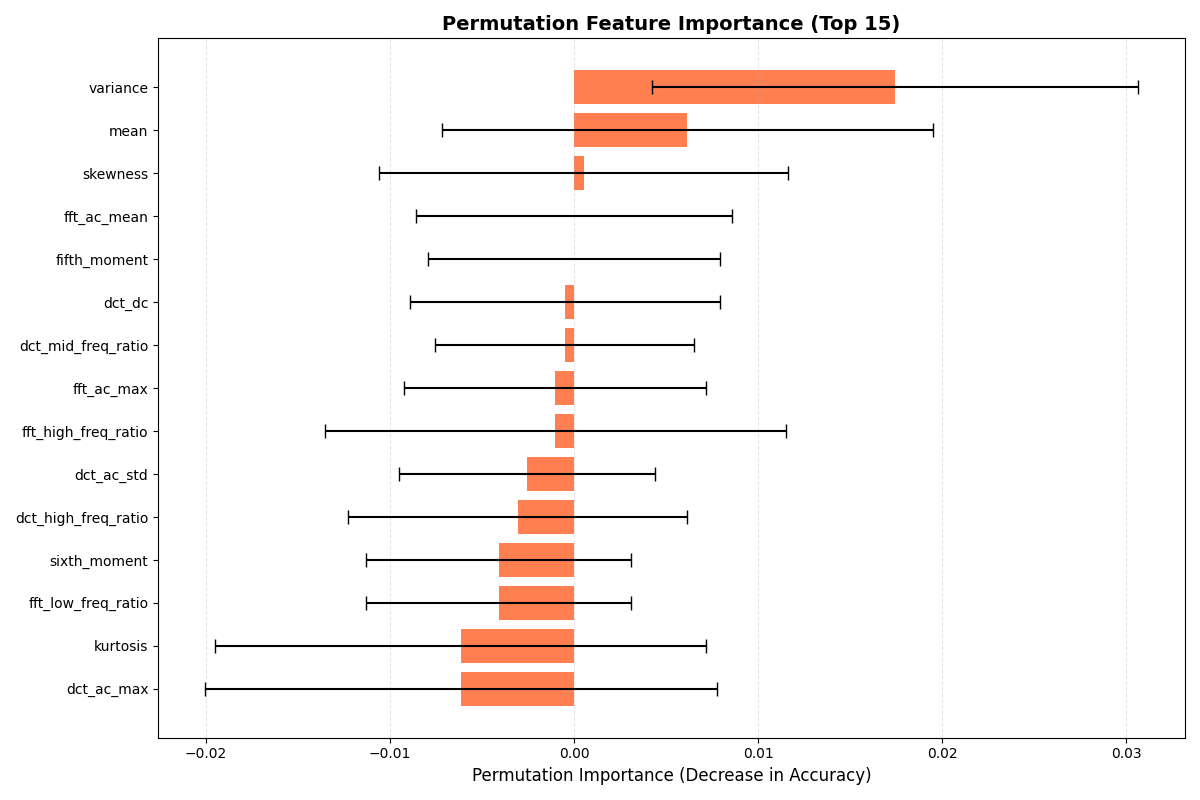

In [ ]:
best_model = grid_search.best_estimator_

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# retrain
best_model.fit(X_train, y_train)

perm_importance = permutation_importance(
    best_model, X_test, y_test, 
    n_repeats=10,  # Number of times to shuffle each feature
    random_state=42,
    n_jobs=8
)


perm_df = pd.DataFrame({
    'feature': features.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print(perm_df.head(20))


# with error bars
fig, ax = plt.subplots(figsize=(12, 8))
top_n = 15
top_perm = perm_df.head(top_n)

y_pos = np.arange(len(top_perm))
ax.barh(y_pos, top_perm['importance_mean'], 
        xerr=top_perm['importance_std'], 
        color='coral', 
        capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_perm['feature'])
ax.invert_yaxis()
ax.set_xlabel('Permutation Importance (Decrease in Accuracy)', fontsize=12)
ax.set_title('Permutation Feature Importance (Top 15)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### Local Explainability (LIME)

shows what the model deems important for specific images. Here we will be using LIME. We choose a single instance (image) that our model predicts a label for, perturb and plot the decision, then train an LR model on the output. This surrogate LR model can be explained even more easily than a random forest.

[('mean > 130.87', -0.05238842906911623), ('skewness <= -0.10', -0.04370429908879884), ('seventh_moment <= -4170658980446.83', -0.043487274027711645), ('fifth_moment <= -346586660.86', -0.03703563572777774), ('0.46 < variance <= 0.57', 0.031599246122932585), ('dct_low_freq_ratio <= 0.34', -0.030104247594333066), ('78817386.00 < fft_dc <= 165936241.25', 0.02733847222352928), ('50254.44 < fft_ac_std <= 75219.52', 0.025163544923160957), ('90232.95 < dct_dc <= 137793.65', 0.021920107577514954), ('dct_high_freq_ratio > 0.08', -0.021343948640232292)]


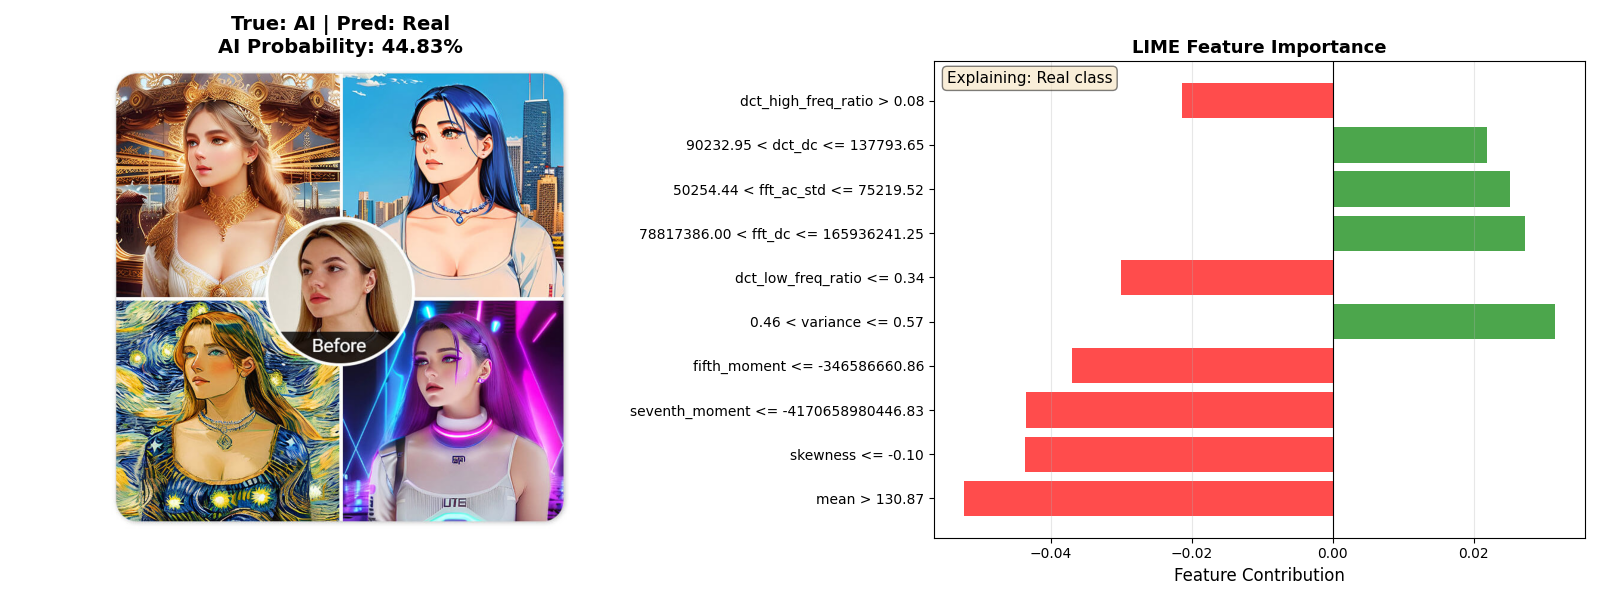

[('variance <= 0.46', -0.09186401165994373), ('mean > 130.87', -0.05160039025434935), ('seventh_moment <= -4170658980446.83', -0.050052845149455724), ('skewness <= -0.10', -0.04696545612122848), ('fft_high_freq_ratio > 0.40', -0.034374556919683934), ('fifth_moment <= -346586660.86', -0.03415460904588874), ('fft_low_freq_ratio <= 0.27', -0.03265442326001433), ('dct_dc > 137793.65', -0.03253537270493883), ('dct_low_freq_ratio <= 0.34', -0.03144876533747369), ('78817386.00 < fft_dc <= 165936241.25', 0.02814632482752173)]


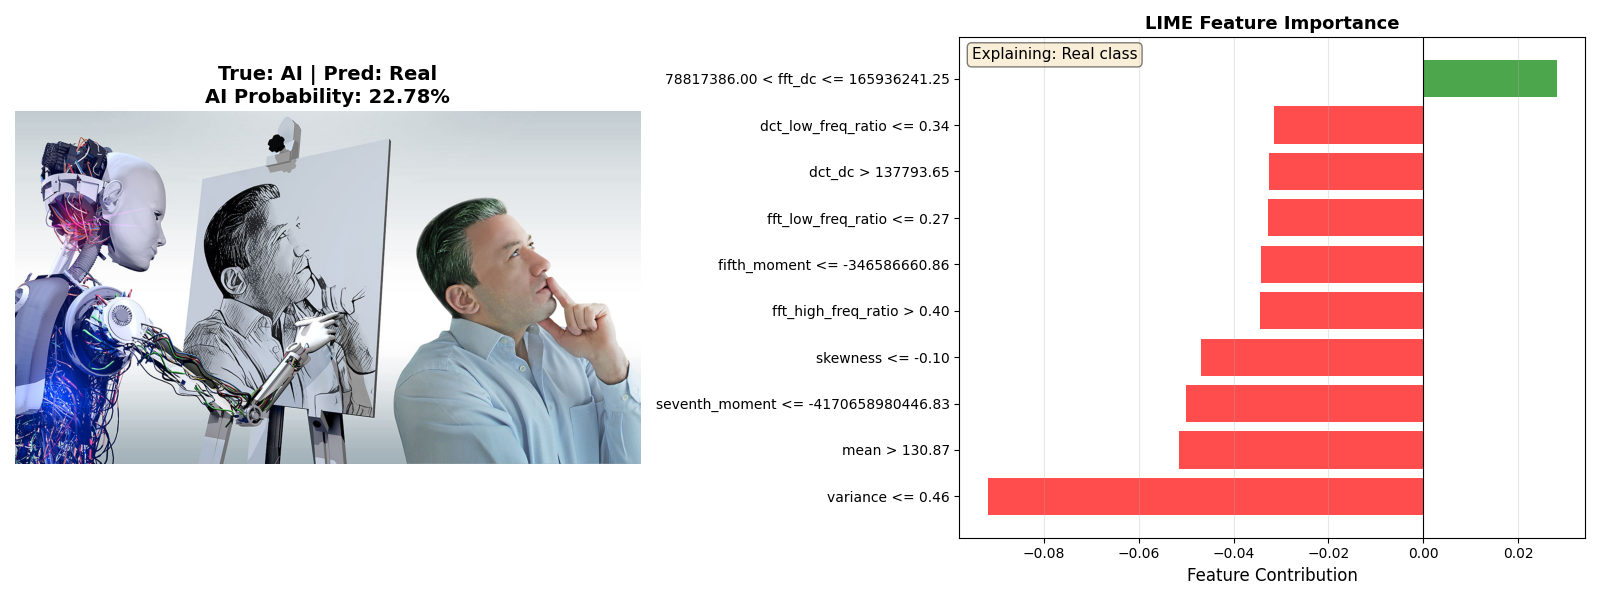

[('variance <= 0.46', -0.09456718954605622), ('skewness <= -0.10', -0.04949082453917464), ('seventh_moment <= -4170658980446.83', -0.04533335574359719), ('fifth_moment <= -346586660.86', -0.0333438070306937), ('78817386.00 < fft_dc <= 165936241.25', 0.02657972159676797), ('dct_high_freq_ratio <= 0.04', 0.025832586829230012), ('90232.95 < dct_dc <= 137793.65', 0.019181444878156626), ('sixth_moment <= 215394675948.47', -0.015032916754037432), ('12438514.90 < fft_ac_max <= 27101578.44', 0.013773832269821724), ('-1.03 < kurtosis <= -0.63', 0.013736762941472047)]


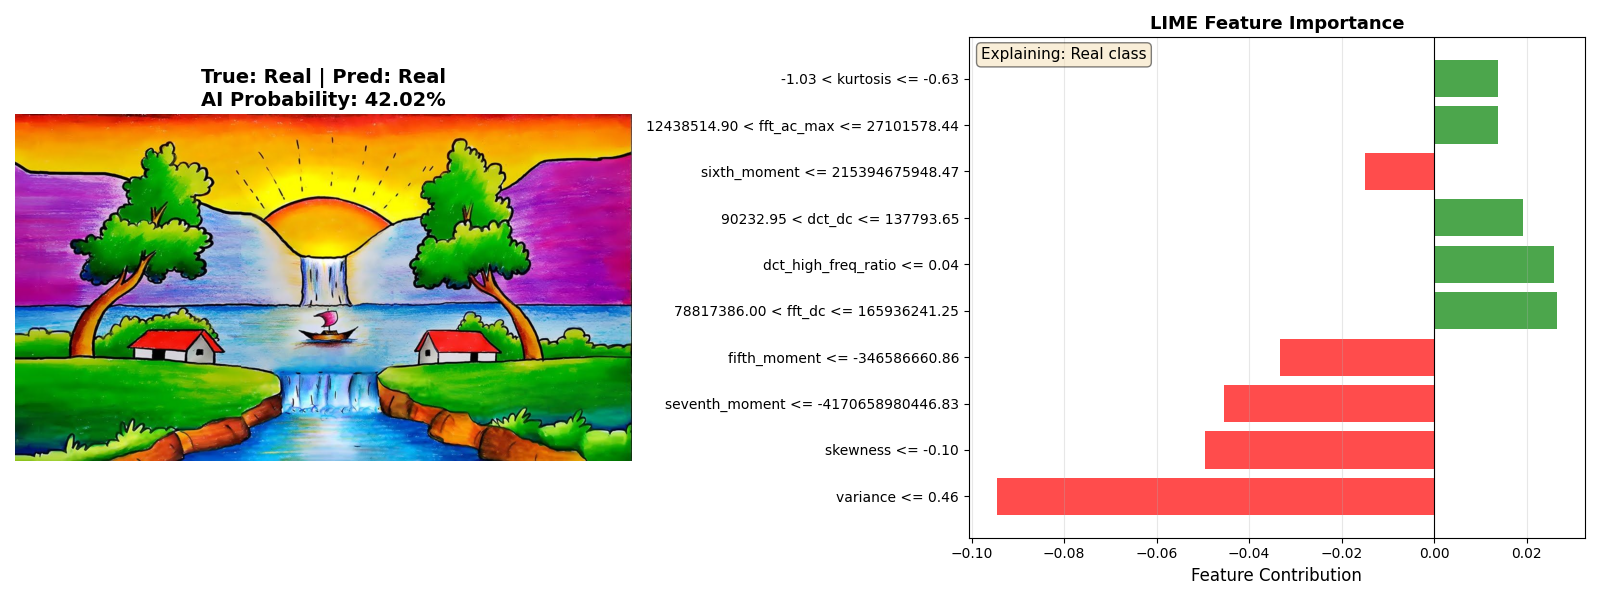

[('variance <= 0.46', -0.09060670834775868), ('skewness <= -0.10', -0.0467737997068396), ('fft_low_freq_ratio <= 0.27', -0.03595868986357137), ('dct_low_freq_ratio <= 0.34', -0.035579255399803), ('fft_high_freq_ratio > 0.40', -0.03470195087451279), ('fft_dc > 165936241.25', -0.033338510067612764), ('83.29 < mean <= 107.51', 0.027333089801536675), ('90232.95 < dct_dc <= 137793.65', 0.02319134125663966), ('-4170658980446.83 < seventh_moment <= 15728853768508.57', -0.0216073084581311), ('dct_high_freq_ratio > 0.08', -0.01964072030384322)]


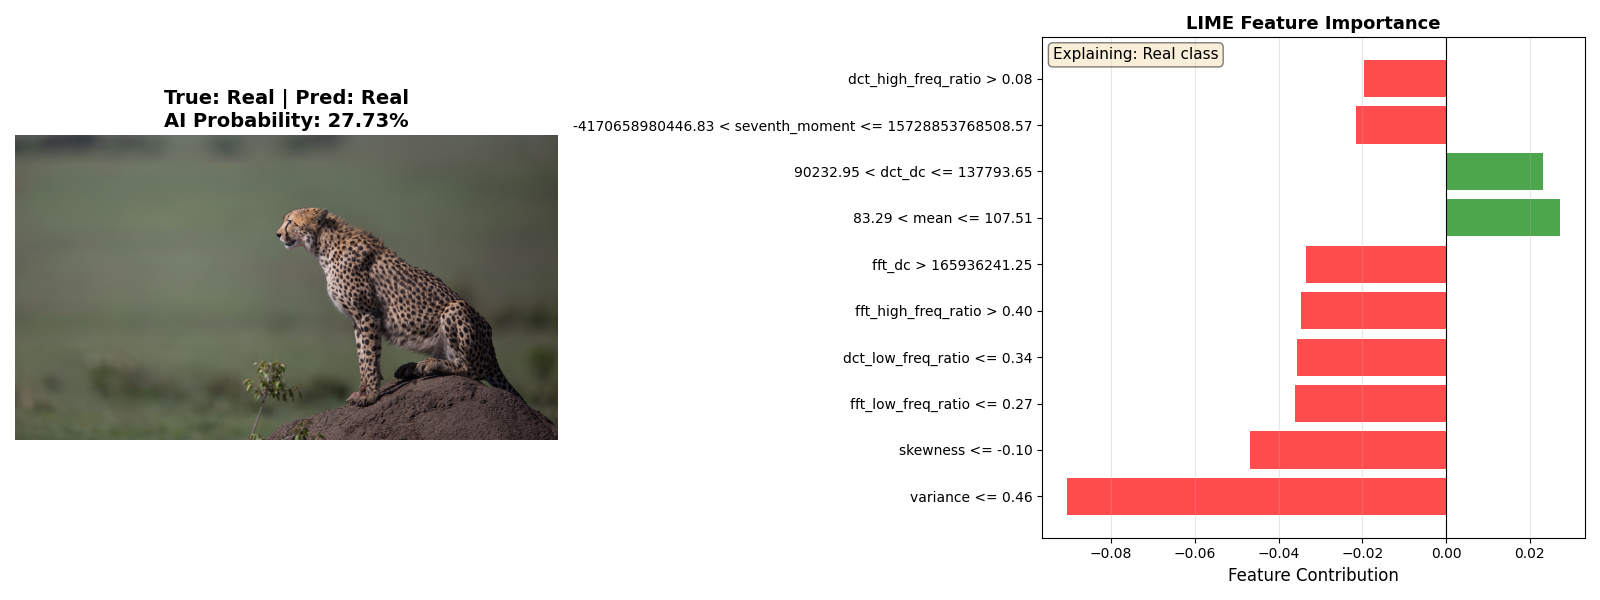

In [ ]:
_, test_indices_full = train_test_split(
    np.arange(len(features)), 
    test_size=0.2, 
    random_state=42
)
test_image_paths = df.iloc[test_indices_full]['image_path'].values

test_indices_ai = np.where(y_test == 1)[0][:2]
test_indices_real = np.where(y_test == 0)[0][:2]


def predict_proba_wrapper(X):
    """simple helper to fix plot warnings"""
    if isinstance(X, np.ndarray):
        X_df = pd.DataFrame(X, columns=feature_names)
        return grid_search.best_estimator_.predict_proba(X_df)
    return grid_search.best_estimator_.predict_proba(X)


# There will be separate figures for each image/explanation, stacked on top of each other
all_test_indices = list(test_indices_ai) + list(test_indices_real)

for i, test_idx in enumerate(all_test_indices):
    actual_image_path = test_image_paths[test_idx]
    
    # 2 subplots for image on left, explanation on right
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    img = Image.open(actual_image_path)
    ax1.imshow(img)
    ax1.axis('off')
    
    # show models prediction
    pred_proba = grid_search.best_estimator_.predict_proba(
        X_test.iloc[test_idx:test_idx+1]
    )[0]
    true_label = y_test.iloc[test_idx]
    pred_label = "AI" if pred_proba[1] > 0.5 else "Real"
    true_label_str = "AI" if true_label == 1 else "Real"
    
    ax1.set_title(
        f'True: {true_label_str} | Pred: {pred_label}\nAI Probability: {pred_proba[1]:.2%}',
        fontsize=14, fontweight='bold'
    )

    feature_names = features.columns.tolist()

    # here we make the LIME explainer with the current training data, it handles all perturbations, linear regression (surrogate), and returns an object of feature importance
    explainer = LimeTabularExplainer(
        X_train.values,
        feature_names=feature_names,
        class_names=['Real', 'AI'],
        mode='classification'
    )
    
    explanation = explainer.explain_instance(
        X_test.iloc[test_idx].values,
        predict_proba_wrapper,
        num_features=10,
    )
    
    exp_list = explanation.as_list()

    print(exp_list)
    
    exp_list_sorted = sorted(exp_list, key=lambda x: abs(x[1]), reverse=True) # sort by magnitude, cleaner visualization 
    features_exp = [x[0] for x in exp_list_sorted]
    values_exp = [x[1] for x in exp_list_sorted]
    
    # Create horizontal bar plot of feature importance
    y_pos = np.arange(len(features_exp))
    colors = ['green' if v > 0 else 'red' for v in values_exp]
    ax2.barh(y_pos, values_exp, color=colors, alpha=0.7)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(features_exp, fontsize=10)
    ax2.set_xlabel('Feature Contribution', fontsize=12)
    ax2.set_title('LIME Feature Importance', fontsize=13, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax2.grid(axis='x', alpha=0.3)
    
    # helpful text annotation showing which class is being explained
    predicted_class_idx = explanation.top_labels[0] if explanation.top_labels else 0
    class_name = "AI" if predicted_class_idx == 1 else "Real"
    ax2.text(0.02, 0.98, f'Explaining: {class_name} class', 
             transform=ax2.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

## Deep Learning Classifier

In this step, we use the torch Dataset and DataLoader to feed a training function which trains a torch model to classify whether the images are real or fake.

We utilize the pre-trained ResNet-50 model, fine-tuned by freezing the weights and trainig the last layer on AI-generated content, then unfreezing the model and lowering the learning rate for additional fine-tuning.

In [ ]:
class Images(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        
    def __getitem__(self, index):
        row = df.iloc[index]
        path = row["image_path"]
        image = Image.open(path).convert('RGB') # may need to permute and make tensor

        if self.transform:
            image = self.transform(image)
        
        target = torch.tensor(row["label"], dtype=torch.long)
        return image, target

    def __len__(self) -> int:
        return len(df)

transform = transforms.v2.Compose([
    v2.Resize((224, 224)),  # ResNet50 expects 224x224
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

data = Images(transform=transform)
data[0]

train_set, test_set = random_split(data, [0.8, 0.2])

print(len(train_set), len(test_set))

train_loader = DataLoader(train_set, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 64, shuffle = False)

780 195


In [ ]:
device = torch.device("cpu")
model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

# freeze early layers and replace last with a fully connected layer
for param in model.parameters():
    param.requires_grad = False
    
# ResNet-50's last layer has 2048 input features
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5), # prevent overfitting
    nn.Linear(num_ftrs, 2)
)

In [ ]:
@dataclass
class TrainingParameters:
    """Updated for AI-Image Detection Regiment"""
    # Phase 1: Training only the head (last layer)
    warmup_epochs: int = 3 
    warmup_lr: float = 1e-3
    
    # Phase 2: Training the full model
    finetune_epochs: int = 7
    finetune_lr: float = 1e-5
    
    gamma: float = 0.7
    dry_run: bool = False
    seed: int = 1
    save_model: bool = True

def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction="sum") # standard for ResNet
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)")

def run_training_epoch(training_params, model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    
    for batch_index, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if training_params.dry_run: break
        if batch_index % (len(train_loader) // 10 + 1) == 0:
            print(".", end="", flush=True)
            
    print(f"\nTrain Epoch: {epoch} \tLoss: {loss.item():.6f}")
    if training_params.save_model:
        torch.save(model.state_dict(), "models/resnet50_ai_detector.pt")

def train(model, training_params, device, train_loader, test_loader):
    """Executes the two-phase training regiment."""
    
    print("\n>>> Phase 1: Training the Head (Backbone Frozen)")

    # filter only params that have grad (the fully connected layer)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=training_params.warmup_lr)
    
    for epoch in range(1, training_params.warmup_epochs + 1):
        run_training_epoch(training_params, model, device, train_loader, optimizer, epoch)
        predict(model, device, test_loader)

    print("\n>>> Phase 2: Fine-Tuning (Full Model Unfrozen)")
    for param in model.parameters():
        param.requires_grad = True
        
    # recreate optimizer with lower LR when training the whole model
    optimizer = optim.Adam(model.parameters(), lr=training_params.finetune_lr)
    scheduler = StepLR(optimizer, step_size=2, gamma=training_params.gamma)

    for epoch in range(1, training_params.finetune_epochs + 1):
        actual_epoch = training_params.warmup_epochs + epoch
        run_training_epoch(training_params, model, device, train_loader, optimizer, actual_epoch)
        predict(model, device, test_loader)
        scheduler.step()

In [ ]:
training_params = TrainingParameters()

if training_params.save_model:
    os.makedirs("models", exist_ok=True)
    
train(model, training_params, device, train_loader, test_loader)


>>> Phase 1: Training the Head (Backbone Frozen)
.......
Train Epoch: 1 	Loss: 0.478814

Test set: Average loss: 0.5468, Accuracy: 148/195 (75.90%)
.......
Train Epoch: 2 	Loss: 0.513391

Test set: Average loss: 0.5132, Accuracy: 144/195 (73.85%)
.......
Train Epoch: 3 	Loss: 0.599370

Test set: Average loss: 0.4947, Accuracy: 149/195 (76.41%)

>>> Phase 2: Fine-Tuning (Full Model Unfrozen)
.......
Train Epoch: 4 	Loss: 0.393011

Test set: Average loss: 0.4845, Accuracy: 152/195 (77.95%)
.......
Train Epoch: 5 	Loss: 0.589520

Test set: Average loss: 0.4718, Accuracy: 154/195 (78.97%)
.......
Train Epoch: 6 	Loss: 0.371432

Test set: Average loss: 0.4626, Accuracy: 153/195 (78.46%)
.......
Train Epoch: 7 	Loss: 0.473742

Test set: Average loss: 0.4570, Accuracy: 154/195 (78.97%)
.......
Train Epoch: 8 	Loss: 0.447046

Test set: Average loss: 0.4541, Accuracy: 155/195 (79.49%)
.......
Train Epoch: 9 	Loss: 0.343096

Test set: Average loss: 0.4497, Accuracy: 153/195 (78.46%)
.......
Tra

## Explainability

Here we use Captum integrated gradients to see which specific pixels actually contributed to the models prediction of AI v.s. Real

In [ ]:
images, labels = next(iter(test_loader))

model.load_state_dict(torch.load("models/resnet50_ai_detector.pt", map_location=device))

model.eval()

/tmp/ipykernel_81431/3981266093.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/resnet50_ai_detector.pt", map_location=device))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

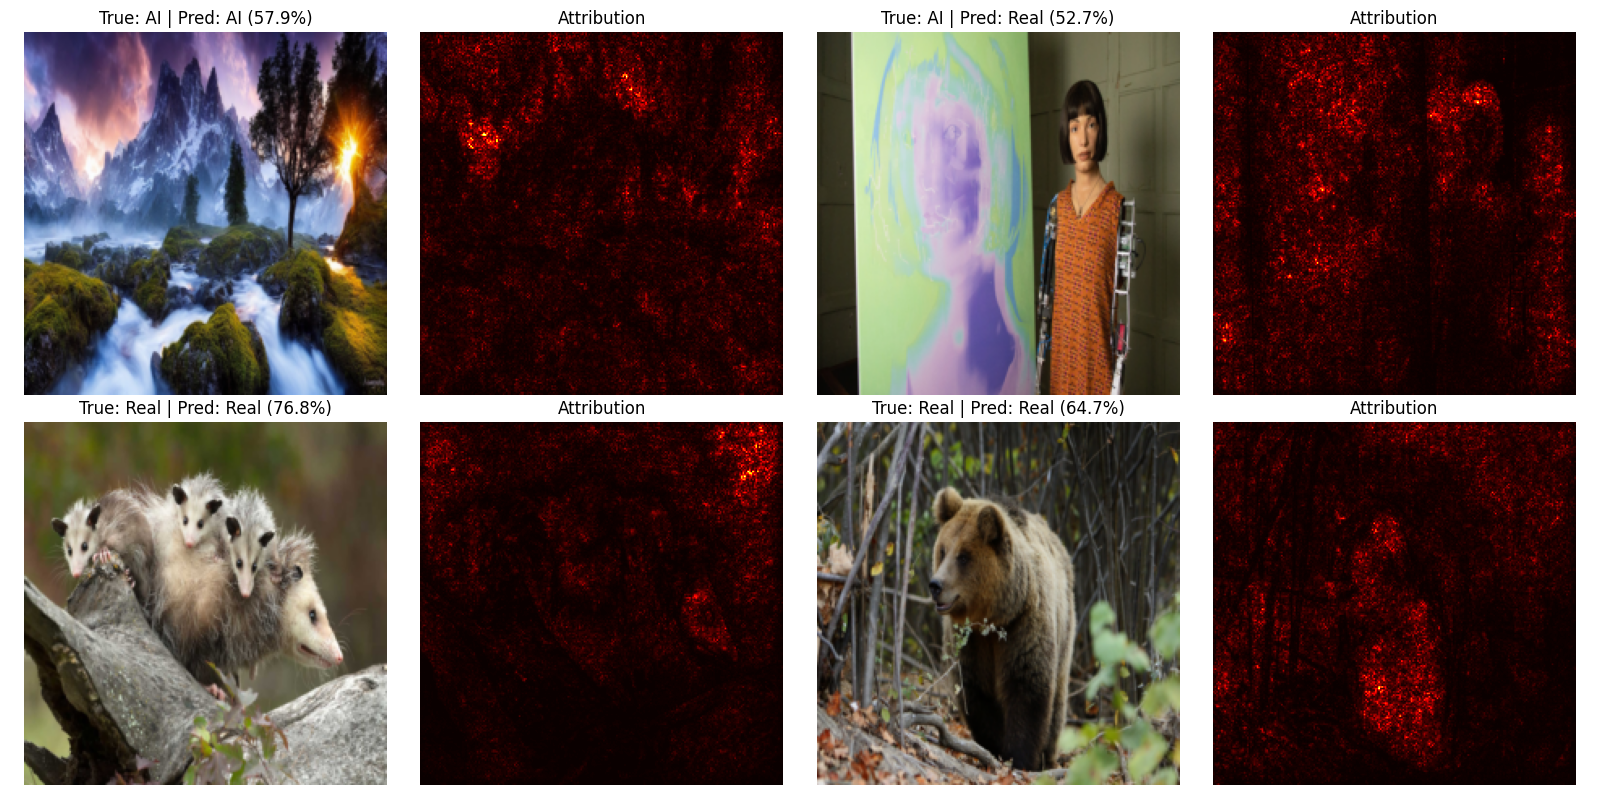

In [ ]:
ig = IntegratedGradients(model)

ai_indices = [i for i, label in enumerate(labels) if label == 1][:2]
real_indices = [i for i, label in enumerate(labels) if label == 0][:2]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for row, indices in enumerate([ai_indices, real_indices]):
    for col, idx in enumerate(indices):
        img = images[idx:idx+1]
        label = labels[idx].item()
        attr = ig.attribute(img, target=label).squeeze().detach().cpu().numpy()
        attr = np.abs(attr).sum(axis=0)  # Sum across RGB channels
        

        orig = img.squeeze().permute(1, 2, 0).detach().cpu().numpy()
        orig = orig * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        orig = np.clip(orig, 0, 1)
        
        with torch.no_grad():
            output = model(img)
            probs = torch.softmax(output, dim=1)[0]
            pred = output.argmax(dim=1).item()
            title = f"True: {'AI' if label==1 else 'Real'} | Pred: {'AI' if pred==1 else 'Real'} ({probs[pred]:.1%})"

        axes[row, col*2].imshow(orig)
        axes[row, col*2].set_title(title)
        axes[row, col*2].axis('off')
        
        axes[row, col*2+1].imshow(attr, cmap='hot')
        axes[row, col*2+1].set_title('Attribution')
        axes[row, col*2+1].axis('off')

plt.tight_layout()
plt.show()


### Results

Interesting to see that I acheived a similiar level of accuracy, with deep learning winning by like 8%. I know theres also much better models than ResNet for this purpose, but at the same time I never looked at image segementation and color channels for the traditional methods.